# Neural Network classification with PyTorch

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:, 0],
                        "X2":X[:, 1],
                        "label":y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


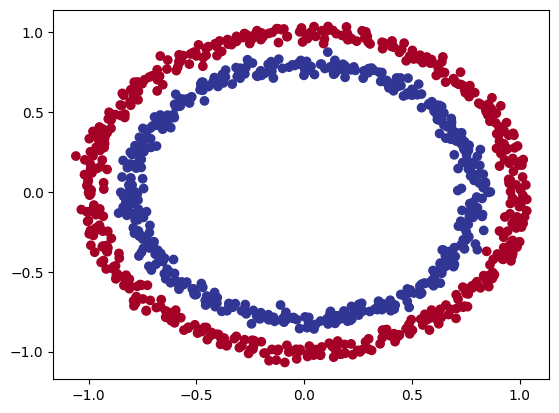

In [5]:
# Visualiza
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]
X_sample, y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), 1, (2,), ())

### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
from sklearn.model_selection import train_test_split

In [9]:
# Turn data into tensors
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X_tensor[:5], y_tensor[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model


In [12]:
import torch
from torch import nn

In [13]:
# 1. setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# 2. Construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features=2, out_features=5)
    self.fc2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [15]:
# instantiate andd instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
# using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4669, -0.4867],
                      [-0.3004,  0.5431],
                      [-0.2950,  0.5376],
                      [ 0.3731,  0.3457],
                      [-0.6704,  0.3358]])),
             ('0.bias', tensor([-0.2255,  0.2526,  0.5380,  0.4105, -0.4569])),
             ('1.weight',
              tensor([[ 0.3655, -0.1990,  0.2514, -0.4458,  0.0741]])),
             ('1.bias', tensor([-0.0552]))])

In [19]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds.shape, len(untrained_preds), torch.round(untrained_preds[:5])

(torch.Size([200, 1]),
 200,
 tensor([[-0.],
         [-1.],
         [ 0.],
         [-0.],
         [-0.]]))

In [20]:
X_test.shape, untrained_preds.shape

(torch.Size([200, 2]), torch.Size([200, 1]))

## 2.1 Setup loss function and optimizer

In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

In [22]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

In [23]:
torch.manual_seed(42)

epochs = 100
losses = []
val_losses = []
accuracy = []
val_accuracy = []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                 y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():

    y_logits = model_0(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    val_loss = loss_fn(y_logits, y_test)
    val_acc = accuracy_fn(y_true=y_test,
                       y_pred=y_pred)

  losses.append(loss)
  val_losses.append(val_loss)
  accuracy.append(acc)
  val_accuracy.append(val_acc)

  if epoch % 10 == 0:
    print(f'epoch:{epoch} | loss:{loss:.5f}, acc:{acc:.2f} | val_loss:{val_loss:.5f}, val_acc:{val_acc:.2f}')

epoch:0 | loss:0.71604, acc:46.12 | val_loss:0.70453, val_acc:51.00
epoch:10 | loss:0.70542, acc:46.88 | val_loss:0.69602, val_acc:53.00
epoch:20 | loss:0.70117, acc:48.38 | val_loss:0.69312, val_acc:52.00
epoch:30 | loss:0.69910, acc:48.88 | val_loss:0.69207, val_acc:52.00
epoch:40 | loss:0.69788, acc:49.62 | val_loss:0.69165, val_acc:52.00
epoch:50 | loss:0.69704, acc:49.88 | val_loss:0.69148, val_acc:52.50
epoch:60 | loss:0.69640, acc:49.88 | val_loss:0.69141, val_acc:51.50
epoch:70 | loss:0.69589, acc:50.00 | val_loss:0.69141, val_acc:51.50
epoch:80 | loss:0.69547, acc:50.12 | val_loss:0.69144, val_acc:50.50
epoch:90 | loss:0.69512, acc:50.38 | val_loss:0.69149, val_acc:50.50


 ## 4. Make predictions

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

--2024-05-21 12:13:57--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-05-21 12:13:57 (71.0 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [25]:
from helper_functions import plot_decision_boundary, plot_predictions

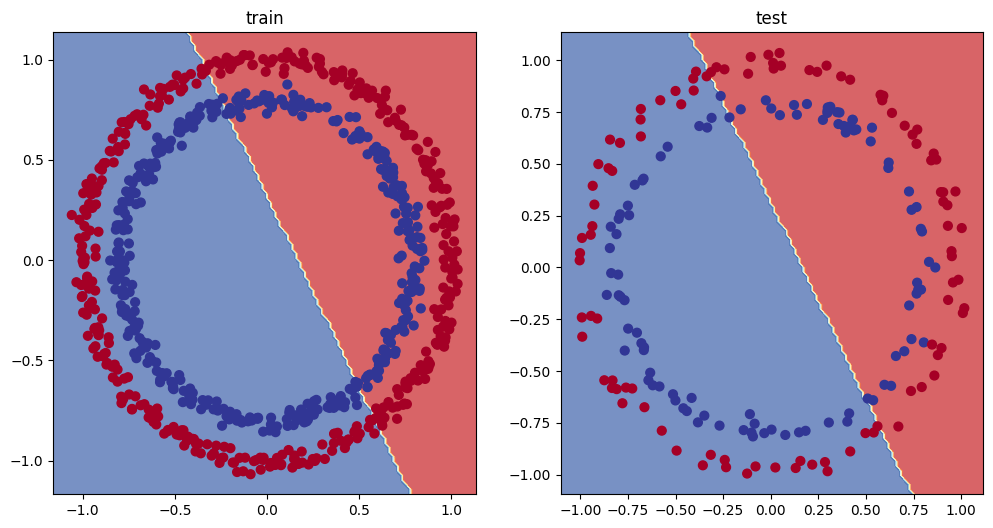

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a modddel perspective)

In [27]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=128)
    self.layer_2 = nn.Linear(in_features=128, out_features=256)
    self.layer_3 = nn.Linear(in_features=256, out_features=1)

  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x)

In [28]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=1, bias=True)
)

In [29]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [30]:
epochs = 1000
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    y_logits = model_1(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits))

    val_loss = loss_fn(y_logits, y_test)
    val_acc = accuracy_fn(y_test, y_pred_test)

  if epoch % 100 == 0:
    print(f"epoch:{epoch} | loss:{loss:.5f}, acc:{acc:.2f}% | val_loss:{val_loss:.5f}, val_acc:{val_acc:.2f}%")


epoch:0 | loss:0.70048, acc:50.00% | val_loss:0.69276, val_acc:44.50%
epoch:100 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:200 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:300 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:400 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:500 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:600 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:700 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:800 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%
epoch:900 | loss:0.69298, acc:51.00% | val_loss:0.69468, val_acc:46.00%


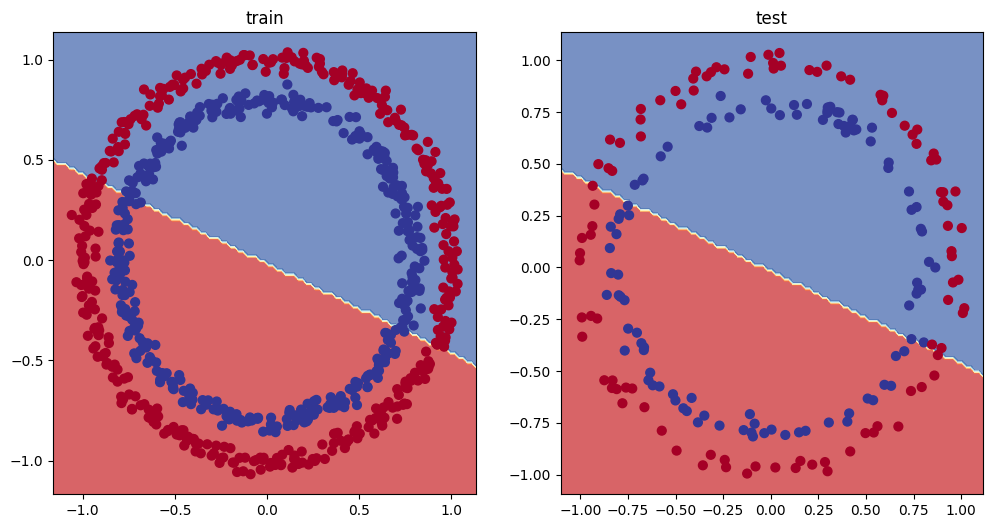

In [31]:
#plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)

In [32]:
weight = 0.5
bias = 0.1

X = torch.arange(1, 10, 0.1).unsqueeze(dim=1)
y = weight * X + bias

In [33]:
X = X.to(device)
y = y.to(device)

In [34]:
class TestModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=1, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x)

model_linear = TestModelV1().to(device)

In [35]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_linear.parameters(),
                            lr=0.001)

In [36]:
for epoch in range(100):
  model_linear.train()
  y_logits = model_linear(X)

  loss = loss_fn(y_logits, y)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



  if epoch % 5 == 0:
    print(f"epoch:{epoch} | loss:{loss:.5f}")

epoch:0 | loss:1.43224
epoch:5 | loss:0.87700
epoch:10 | loss:0.29393
epoch:15 | loss:0.14085
epoch:20 | loss:0.13844
epoch:25 | loss:0.13604
epoch:30 | loss:0.13365
epoch:35 | loss:0.13127
epoch:40 | loss:0.12890
epoch:45 | loss:0.12654
epoch:50 | loss:0.12419
epoch:55 | loss:0.12185
epoch:60 | loss:0.11951
epoch:65 | loss:0.11718
epoch:70 | loss:0.11486
epoch:75 | loss:0.11255
epoch:80 | loss:0.11025
epoch:85 | loss:0.10796
epoch:90 | loss:0.10567
epoch:95 | loss:0.10339


## 6.1 Recreating non-linear data

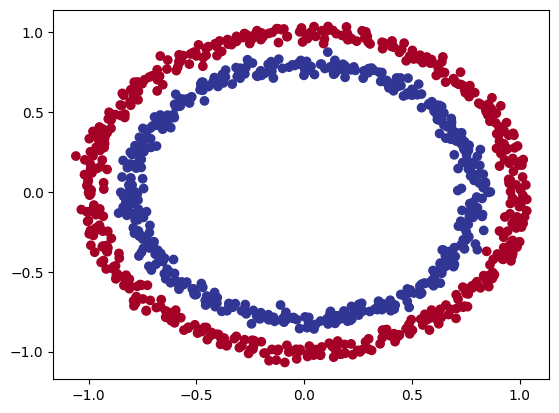

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [57]:
import torch
from sklearn.model_selection import train_test_split

X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [79]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()



  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)

    return self.layer_3(x)

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [80]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

In [83]:
epochs = 1000
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    y_logits = model_2(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits))
    val_loss = loss_fn(y_pred_test, y_test)
    val_acc = accuracy_fn(y_test, y_pred_test)

  if epoch % 10 == 0:
    print(f'epoch:{epoch} | loss:{loss:.5f}, acc:{acc:.2f}% | val_loss:{val_loss:.5f}, val_acc:{val_acc:.2f}%')


epoch:0 | loss:0.68977, acc:57.88% | val_loss:0.72510, val_acc:55.50%
epoch:10 | loss:0.68959, acc:59.38% | val_loss:0.71890, val_acc:56.50%
epoch:20 | loss:0.68940, acc:61.75% | val_loss:0.71270, val_acc:57.50%
epoch:30 | loss:0.68920, acc:64.38% | val_loss:0.69720, val_acc:60.00%
epoch:40 | loss:0.68900, acc:66.25% | val_loss:0.68170, val_acc:62.50%
epoch:50 | loss:0.68878, acc:66.88% | val_loss:0.67860, val_acc:63.00%
epoch:60 | loss:0.68855, acc:67.75% | val_loss:0.67860, val_acc:63.00%
epoch:70 | loss:0.68831, acc:68.75% | val_loss:0.67549, val_acc:63.50%
epoch:80 | loss:0.68806, acc:69.38% | val_loss:0.67239, val_acc:64.00%
epoch:90 | loss:0.68780, acc:69.62% | val_loss:0.66309, val_acc:65.50%
epoch:100 | loss:0.68753, acc:69.75% | val_loss:0.66499, val_acc:65.00%
epoch:110 | loss:0.68725, acc:69.50% | val_loss:0.66499, val_acc:65.00%
epoch:120 | loss:0.68695, acc:69.25% | val_loss:0.65949, val_acc:65.50%
epoch:130 | loss:0.68664, acc:69.62% | val_loss:0.66519, val_acc:64.00%
epo

### 6.4 Evaluating the model

In [84]:
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

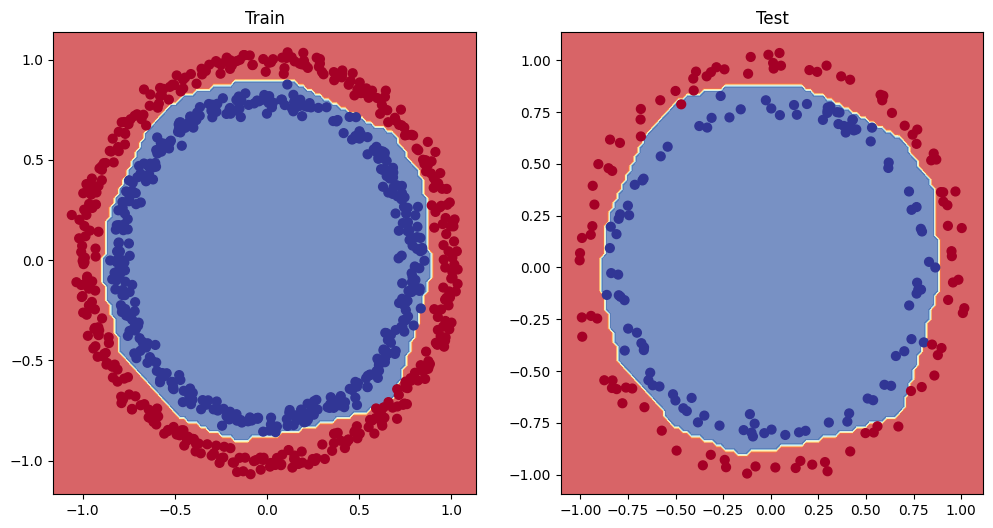

In [87]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

### 7. Replicating non-linear activation functions

In [89]:
A = torch.arange(-10, 10, 1.0)
A.dtype

torch.float32

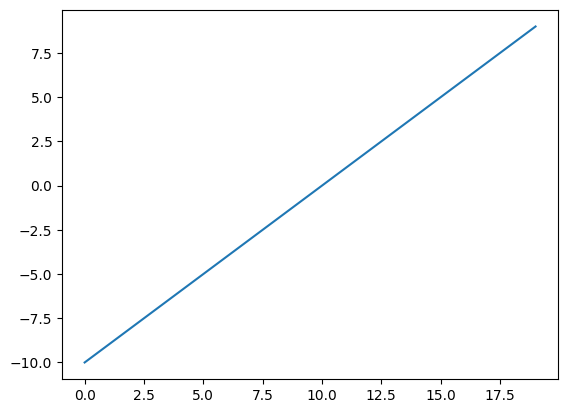

In [90]:
# Visualize the tensor
plt.plot(A)

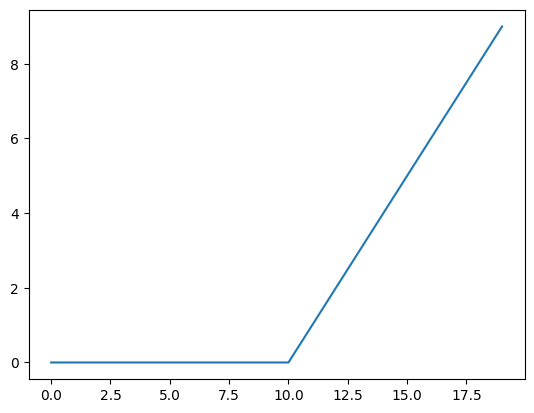

In [93]:
plt.plot(torch.relu(A))

In [94]:
def relu(X):
  return torch.maximum(torch.tensor(0), X)

In [95]:
B = relu(A)

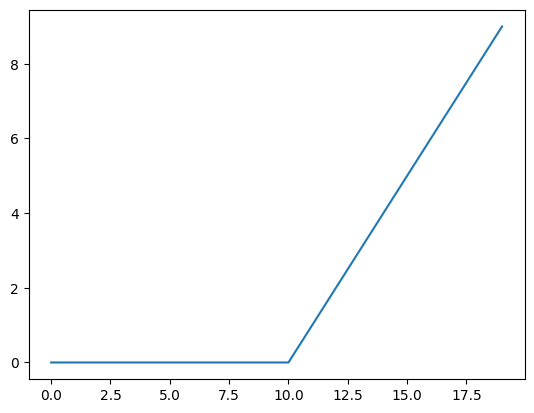

In [96]:
plt.plot(B)

In [97]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

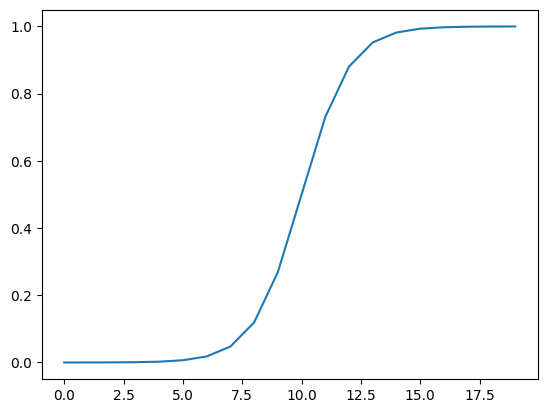

In [98]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy muti-class dataset

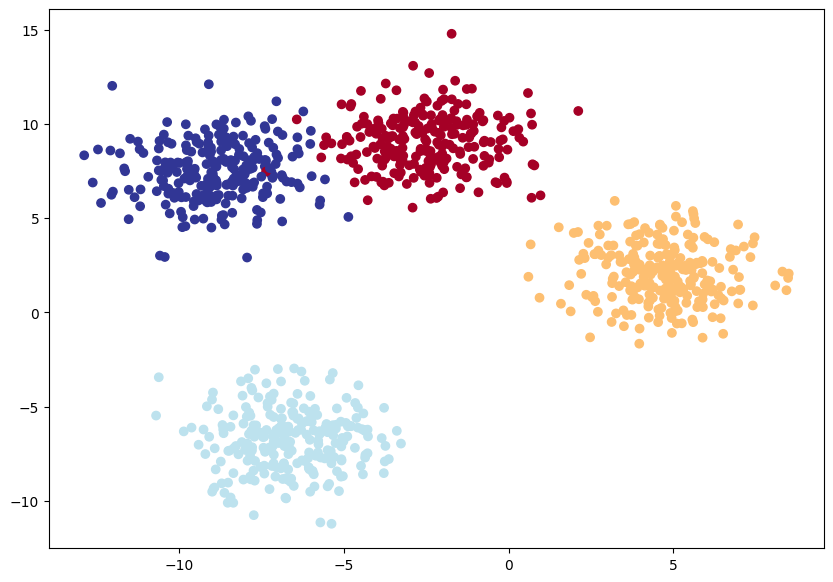

In [103]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


# Set the hyperparamters for data creating
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [111]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MultiClassModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
    # self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
    # self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    # self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    # self.relu = nn.ReLU()
    # self.softmax = nn.Softmax()

  def forward(self, x):
    return self.linear_layer_statck(x)

model_3 = MultiClassModel(NUM_FEATURES, NUM_CLASSES).to(device)
model_3

MultiClassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)